# VTT Innovation Duplicate Candidates - Exploratory Data Analysis

**Objective:** Analyze the JSON output from the enhanced FAISS duplicate detection script with full context integration to understand patterns in potential innovation duplicates.

**Data Source:** JSON output from `ambiguity_analysis_ollama_v4.py` (Enhanced Context Version)

**Key Questions:**
- How do URL and domain matches improve duplicate detection accuracy?
- What is the impact of VTT involvement tracking on collaboration insights?
- How do multilingual variants (Finnish ↔ English) appear in the data?
- What is the distribution of context-enhanced confidence scores?
- How effective are cross-platform innovation mentions for validation?


In [20]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from typing import List, Optional, Dict, Any
from pydantic import BaseModel, Field
from datetime import datetime
import warnings

In [21]:
# Configure plotting style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
warnings.filterwarnings("ignore")

In [22]:
# Set display options for better DataFrame viewing
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", 100)

# 2. Data Models (Optional Validation)

Define Pydantic models to validate the structure of our JSON data.
These should match the models used in the FAISS analysis script.

In [23]:
class InnovationMention(BaseModel):
    """Enhanced innovation mention with full context from original data."""

    unique_mention_id: str
    original_id: str
    name: str
    description: str = ""
    source_doc_id: str
    dataset_origin: str
    associated_orgs: List[str] = Field(default_factory=list)
    non_vtt_orgs: List[str] = Field(default_factory=list)  # Organizations excluding VTT

    # Original context from CSV data
    source_url: Optional[str] = None
    page_title: Optional[str] = None
    website_domain: Optional[str] = None
    publication_date: Optional[str] = None
    document_type: Optional[str] = None
    company_name: Optional[str] = None
    has_vtt_involvement: bool = False


class DuplicateMatch(BaseModel):
    """Enhanced duplicate match with context-based reasoning."""

    innovation1: InnovationMention
    innovation2: InnovationMention
    similarity_score: float
    shared_non_vtt_orgs: List[str]  # Updated field name
    confidence_level: str = "medium"
    match_reasons: List[str] = Field(default_factory=list)  # New field
    url_match: bool = False  # New field
    domain_match: bool = False  # New field


class AnalysisResults(BaseModel):
    """Complete enhanced analysis results."""

    total_raw_mentions: int
    unique_innovations: int
    duplicates: List[DuplicateMatch]
    source_counts: Dict[str, int]
    processing_time: float
    config: Dict[str, Any]
    timestamp: datetime


print("✅ Enhanced data models defined")

✅ Enhanced data models defined


# 3. Data Loading and Initial Processing

Configure the path to your JSON output file
Update this path to match your actual output file

In [24]:
JSON_FILE_PATH = (
    "output/vtt_enhanced_analysis_20250531_135030.json"  # Update with your actual file
)

print(f"📂 Loading enhanced data from: {JSON_FILE_PATH}")

try:
    with open(JSON_FILE_PATH, "r", encoding="utf-8") as f:
        analysis_data_raw = json.load(f)

    print("✅ JSON file loaded successfully")

    # Optional: Validate with Pydantic models
    try:
        analysis_results = AnalysisResults(**analysis_data_raw)
        duplicate_pairs_raw = [dup.model_dump() for dup in analysis_results.duplicates]
        print("✅ Data successfully validated with enhanced Pydantic models")

        # Display enhanced summary statistics
        print(f"\n📊 Enhanced Analysis Summary:")
        print(f"   • Total raw mentions: {analysis_results.total_raw_mentions:,}")
        print(f"   • Unique innovation names: {analysis_results.unique_innovations:,}")
        print(f"   • Potential duplicate pairs: {len(analysis_results.duplicates):,}")
        print(f"   • Processing time: {analysis_results.processing_time:.2f} seconds")

        # Enhanced configuration info
        config = analysis_results.config
        print(f"\n🔧 Enhanced Configuration:")
        print(
            f"   • Uses original context: {config.get('uses_original_context', 'Unknown')}"
        )
        print(f"   • Filters VTT: {config.get('filters_vtt', 'Unknown')}")
        print(
            f"   • Similarity threshold: {config.get('similarity_threshold', 'Unknown')}"
        )

    except Exception as e:
        print(f"⚠️  Pydantic validation error: {e}")
        print("   Proceeding with raw dictionary data...")
        duplicate_pairs_raw = analysis_data_raw.get("duplicates", [])

except FileNotFoundError:
    print(f"❌ Error: File not found at {JSON_FILE_PATH}")
    print("   Please update the JSON_FILE_PATH variable with the correct path.")
    raise
except Exception as e:
    print(f"❌ Error loading JSON file: {e}")
    raise

# Extract duplicate pairs for analysis
duplicate_pairs_raw = analysis_data_raw.get("duplicates", [])
print(
    f"\n🔍 Found {len(duplicate_pairs_raw)} potential duplicate pairs for enhanced analysis"
)

📂 Loading enhanced data from: output/vtt_enhanced_analysis_20250531_135030.json
✅ JSON file loaded successfully
✅ Data successfully validated with enhanced Pydantic models

📊 Enhanced Analysis Summary:
   • Total raw mentions: 3,505
   • Unique innovation names: 2,889
   • Potential duplicate pairs: 2,197
   • Processing time: 2.78 seconds

🔧 Enhanced Configuration:
   • Uses original context: True
   • Filters VTT: False
   • Similarity threshold: 0.8

🔍 Found 2197 potential duplicate pairs for enhanced analysis


# 4. Data Transformation to DataFrame

Convert the nested JSON structure to a flat Pandas DataFrame for easier analysis and visualization.


In [25]:
def flatten_enhanced_duplicate_pairs(duplicate_pairs_raw):
    """
    Transform enhanced nested duplicate pair structure into a flat DataFrame.

    Args:
        duplicate_pairs_raw: List of enhanced duplicate pair dictionaries from JSON

    Returns:
        pd.DataFrame: Flattened data with context and enhancement fields
    """
    flat_data = []

    for pair in duplicate_pairs_raw:
        flat_data.append(
            {
                # Innovation 1 details
                "mention_id_1": pair["innovation1"]["unique_mention_id"],
                "name_1": pair["innovation1"]["name"],
                "origin_1": pair["innovation1"]["dataset_origin"],
                "non_vtt_orgs_1_count": len(pair["innovation1"]["non_vtt_orgs"]),
                "source_doc_1": pair["innovation1"]["source_doc_id"],
                "has_vtt_1": pair["innovation1"]["has_vtt_involvement"],
                # Innovation 1 context
                "source_url_1": pair["innovation1"].get("source_url"),
                "page_title_1": pair["innovation1"].get("page_title"),
                "website_domain_1": pair["innovation1"].get("website_domain"),
                "publication_date_1": pair["innovation1"].get("publication_date"),
                "document_type_1": pair["innovation1"].get("document_type"),
                "company_name_1": pair["innovation1"].get("company_name"),
                # Innovation 2 details
                "mention_id_2": pair["innovation2"]["unique_mention_id"],
                "name_2": pair["innovation2"]["name"],
                "origin_2": pair["innovation2"]["dataset_origin"],
                "non_vtt_orgs_2_count": len(pair["innovation2"]["non_vtt_orgs"]),
                "source_doc_2": pair["innovation2"]["source_doc_id"],
                "has_vtt_2": pair["innovation2"]["has_vtt_involvement"],
                # Innovation 2 context
                "source_url_2": pair["innovation2"].get("source_url"),
                "page_title_2": pair["innovation2"].get("page_title"),
                "website_domain_2": pair["innovation2"].get("website_domain"),
                "publication_date_2": pair["innovation2"].get("publication_date"),
                "document_type_2": pair["innovation2"].get("document_type"),
                "company_name_2": pair["innovation2"].get("company_name"),
                # Enhanced pair relationship details
                "similarity_score": pair["similarity_score"],
                "shared_non_vtt_orgs_count": len(pair["shared_non_vtt_orgs"]),
                "confidence_level": pair["confidence_level"],
                "url_match": pair.get("url_match", False),
                "domain_match": pair.get("domain_match", False),
                "match_reasons": ", ".join(pair.get("match_reasons", [])),
                # Descriptions (truncated)
                "description_1": pair["innovation1"].get("description", "")[:200]
                + "..."
                if len(pair["innovation1"].get("description", "")) > 200
                else pair["innovation1"].get("description", ""),
                "description_2": pair["innovation2"].get("description", "")[:200]
                + "..."
                if len(pair["innovation2"].get("description", "")) > 200
                else pair["innovation2"].get("description", ""),
            }
        )

    return pd.DataFrame(flat_data)


# Transform enhanced data
df_duplicates = flatten_enhanced_duplicate_pairs(duplicate_pairs_raw)

print("✅ Enhanced DataFrame created successfully")
print(f"\n📋 Enhanced DataFrame Info:")
print(f"   • Shape: {df_duplicates.shape}")
print(
    f"   • Memory usage: {df_duplicates.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB"
)

# Display first few rows
print(f"\n🔍 First 5 rows of enhanced data:")
display(df_duplicates.head())

# Basic statistics
print(f"\n📈 Enhanced Basic Statistics:")
enhanced_stats_cols = [
    "similarity_score",
    "shared_non_vtt_orgs_count",
    "non_vtt_orgs_1_count",
    "non_vtt_orgs_2_count",
]
print(df_duplicates[enhanced_stats_cols].describe())

✅ Enhanced DataFrame created successfully

📋 Enhanced DataFrame Info:
   • Shape: (2197, 32)
   • Memory usage: 3.67 MB

🔍 First 5 rows of enhanced data:


,mention_id_1,name_1,origin_1,non_vtt_orgs_1_count,source_doc_1,has_vtt_1,source_url_1,page_title_1,website_domain_1,publication_date_1,document_type_1,company_name_1,mention_id_2,name_2,origin_2,non_vtt_orgs_2_count,source_doc_2,has_vtt_2,source_url_2,page_title_2,website_domain_2,publication_date_2,document_type_2,company_name_2,similarity_score,shared_non_vtt_orgs_count,confidence_level,url_match,domain_match,match_reasons,description_1,description_2
0,Solar Foods protein production technology_2_0,Solar Foods protein production technology,graph_docs_vtt_domain_names_resolved,1,FI28721168_511,True,https://www.vttresearch.com/en/news-and-ideas/three-key-components-sustainable-development-deep-...,VTT Domain Page,vtt_domain,Unknown,VTT_Domain,VTT,Neo-Carbon Food protein production process_903_1,Neo-Carbon Food protein production process,graph_docs_vtt_domain_names_resolved,2,FI02458939_77,True,https://www.vttresearch.com/fi/uutiset-ja-tarinat/ruokaa-ilmasta-uudella-prosessilla,VTT Domain Page,vtt_domain,Unknown,VTT_Domain,VTT,0.976473,1,high,False,True,"Same website domain, Shared organizations: 1, Same document type, Same company source",A protein production technology developed jointly by VTT and LUT University that produces protei...,A new process for producing protein from atmospheric carbon dioxide and water using integrated w...
1,Solar Foods protein production technology_2_0,Solar Foods protein production technology,graph_docs_vtt_domain_names_resolved,1,FI28721168_511,True,https://www.vttresearch.com/en/news-and-ideas/three-key-components-sustainable-development-deep-...,VTT Domain Page,vtt_domain,Unknown,VTT_Domain,VTT,Ruokaa ilmasta uudella prosessilla_903_0,Ruokaa ilmasta uudella prosessilla,graph_docs_vtt_domain_names_resolved,1,FI02458939_77,True,https://www.vttresearch.com/fi/uutiset-ja-tarinat/ruokaa-ilmasta-uudella-prosessilla,VTT Domain Page,vtt_domain,Unknown,VTT_Domain,VTT,0.969724,1,high,False,True,"Same website domain, Shared organizations: 1, Same document type, Same company source",A protein production technology developed jointly by VTT and LUT University that produces protei...,"A new process for protein production from air developed jointly by LUT University and VTT, utili..."
2,BIOASSEMBLER-projekti_10_0,BIOASSEMBLER-projekti,graph_docs_vtt_domain_names_resolved,5,FI27266845_607,True,https://www.vttresearch.com/fi/uutiset-ja-tarinat/bioalykkaat-valmistusprosessit-avaavat-tieta-u...,VTT Domain Page,vtt_domain,Unknown,VTT_Domain,VTT,BIOASSEMBLER - Integrating bio-inspired assembly into semiconductor manufacturing technology for...,BIOASSEMBLER - Integrating bio-inspired assembly into semiconductor manufacturing technology for...,graph_docs_vtt_domain_names_resolved,5,FI27266845_577,True,https://www.vttresearch.com/en/news-and-ideas/bio-intelligent-micromanufacturing-paves-way-new-b...,VTT Domain Page,vtt_domain,Unknown,VTT_Domain,VTT,1.000000,3,high,False,True,"Same website domain, Shared organizations: 3, Same document type, Same company source",New generation biochips (bioMEMS biosensors) developed by integrating bio-inspired assembly into...,An innovation involving a new generation of biosensors manufactured through bio-intelligent proc...
3,Teollinen metaversumi_12_0,Teollinen metaversumi,graph_docs_vtt_domain_names_resolved,0,FI23025702_1157,True,https://www.vttresearch.com/fi/palvelut/ihmislahtoisen-teollisen-metaversumin-ratkaisut,VTT Domain Page,vtt_domain,Unknown,VTT_Domain,VTT,Human-driven Industrial metaverse_12_1,Human-driven Industrial metaverse,graph_docs_vtt_domain_names_resolved,10,FI23025702_1157,False,https://www.vttresearch.com/fi/palvelut/ihmislahtoisen-teollisen-metaversumin-ratkaisut,VTT Domain Page,vtt_domain,Unknown,VTT_Domain,VTT,1.000000,0,high,True,True,"Same source URL, Same document type, Same company source",Industrial metaverse is a new virtual collaboration environment that integrates physical and vir...,A novel virtual collaboration environment combining physical and vi


📈 Enhanced Basic Statistics:
       similarity_score  shared_non_vtt_orgs_count  non_vtt_orgs_1_count  \
count       2197.000000                2197.000000           2197.000000   
mean           0.934586                   1.944470              2.979062   
std            0.062080                   2.374464              3.183450   
min            0.800204                   0.000000              0.000000   
25%            0.880505                   1.000000              1.000000   
50%            0.946351                   1.000000              2.000000   
75%            1.000000                   2.000000              4.000000   
max            1.000000                  21.000000             24.000000   

       non_vtt_orgs_2_count  
count           2197.000000  
mean               3.192080  
std                3.589155  
min                0.000000  
25%                1.000000  
50%                2.000000  
75%                4.000000  
max               26.000000  


# 5. Similarity Score Analysis

Analyze the distribution of cosine similarity scores to understand the quality of candidate pairs.


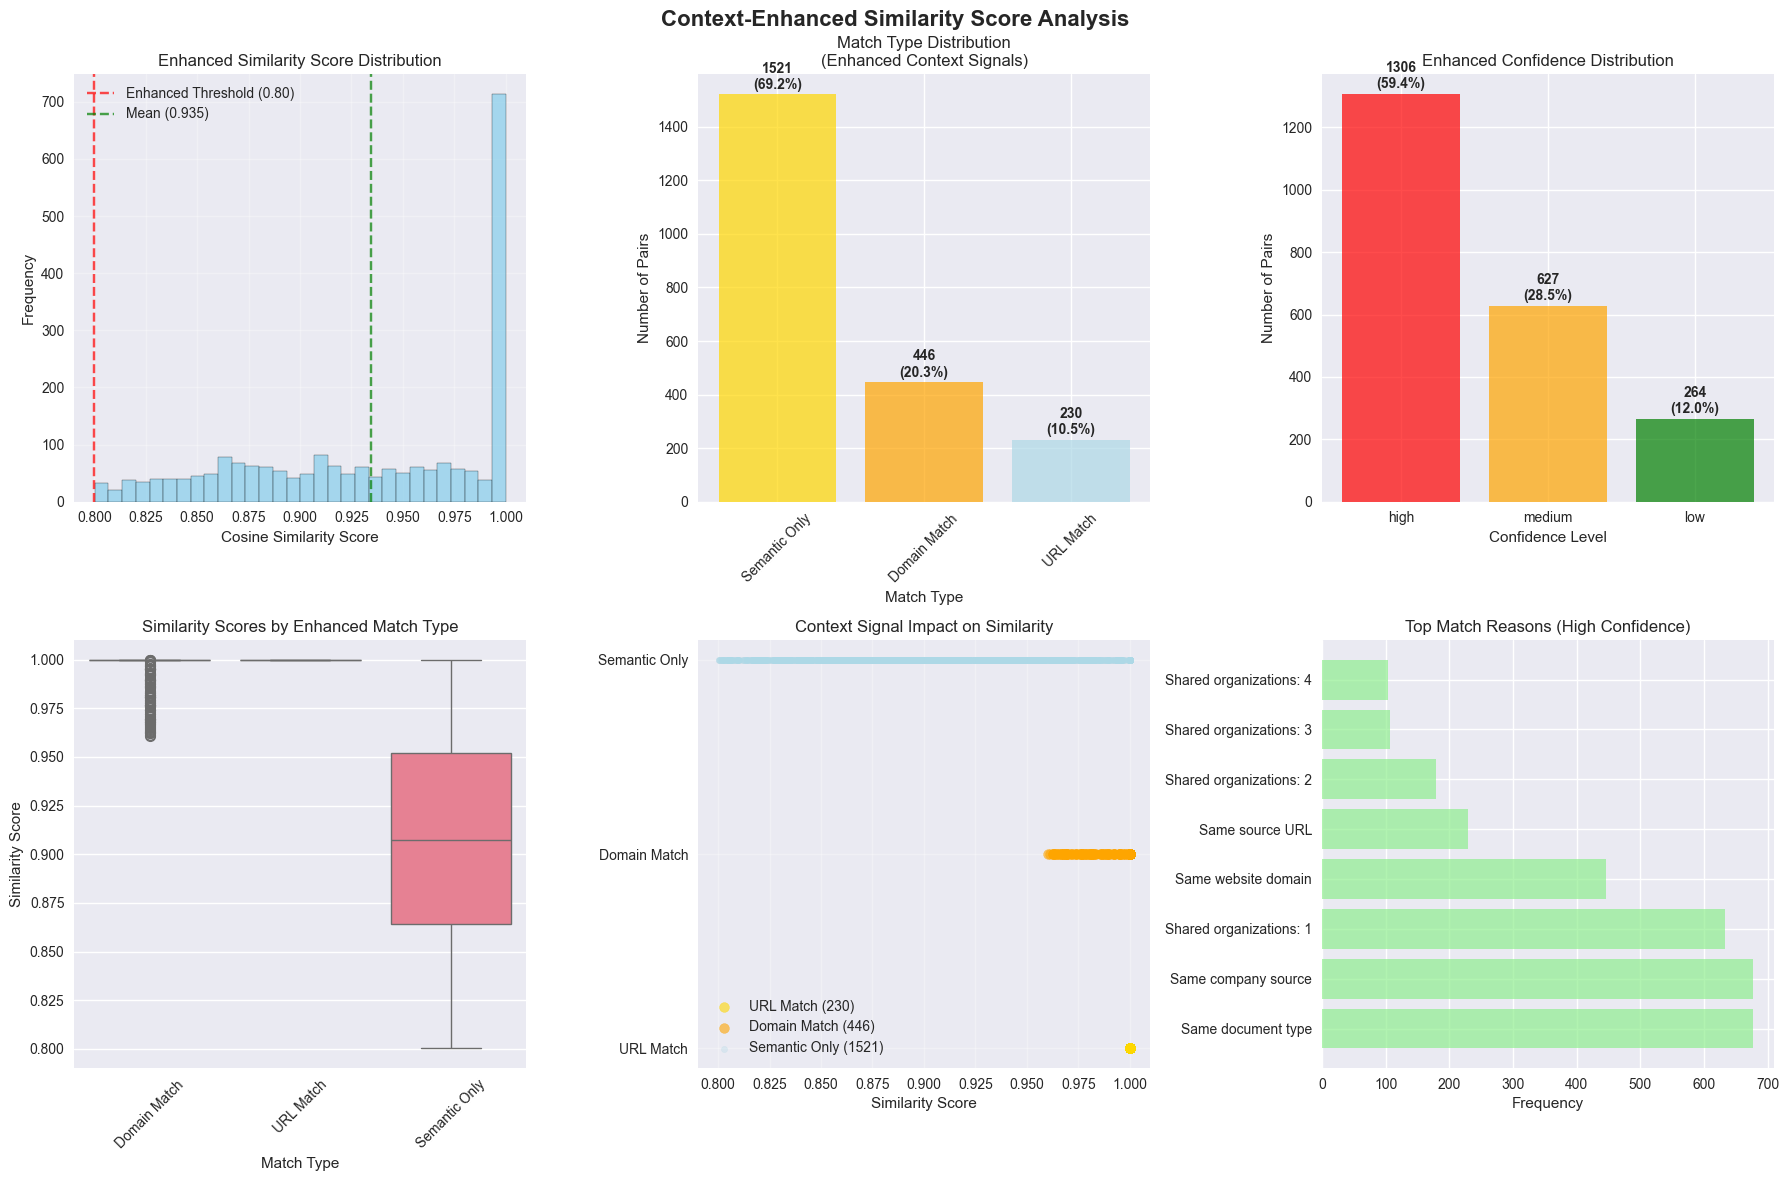

📊 Context-Enhanced Similarity Statistics:
   • URL matches: 230 (10.5%)
   • Domain matches: 446 (20.3%)
   • Semantic only: 1521 (69.2%)
   • High confidence: 1306 (59.4%)


In [26]:
# Enhanced similarity analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(
    "Context-Enhanced Similarity Score Analysis", fontsize=16, fontweight="bold"
)

# 1. Overall distribution with context signals
axes[0, 0].hist(
    df_duplicates["similarity_score"],
    bins=30,
    alpha=0.7,
    color="skyblue",
    edgecolor="black",
)
axes[0, 0].set_title("Enhanced Similarity Score Distribution")
axes[0, 0].set_xlabel("Cosine Similarity Score")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].grid(True, alpha=0.3)

# Add enhanced thresholds
axes[0, 0].axvline(
    x=0.80, color="red", linestyle="--", alpha=0.7, label="Enhanced Threshold (0.80)"
)
axes[0, 0].axvline(
    x=df_duplicates["similarity_score"].mean(),
    color="green",
    linestyle="--",
    alpha=0.7,
    label=f"Mean ({df_duplicates['similarity_score'].mean():.3f})",
)
axes[0, 0].legend()

# 2. URL vs Domain vs Semantic matches
match_types = []
for _, row in df_duplicates.iterrows():
    if row["url_match"]:
        match_types.append("URL Match")
    elif row["domain_match"]:
        match_types.append("Domain Match")
    else:
        match_types.append("Semantic Only")

df_duplicates["match_type_category"] = match_types
match_type_counts = pd.Series(match_types).value_counts()

axes[0, 1].bar(
    match_type_counts.index,
    match_type_counts.values,
    color=["gold", "orange", "lightblue"],
    alpha=0.7,
)
axes[0, 1].set_title("Match Type Distribution\n(Enhanced Context Signals)")
axes[0, 1].set_xlabel("Match Type")
axes[0, 1].set_ylabel("Number of Pairs")
axes[0, 1].tick_params(axis="x", rotation=45)

# Add percentage labels
total_pairs = len(df_duplicates)
for i, (label, count) in enumerate(match_type_counts.items()):
    axes[0, 1].text(
        i,
        count + 10,
        f"{count}\n({count / total_pairs * 100:.1f}%)",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

# 3. Enhanced confidence distribution
conf_counts = df_duplicates["confidence_level"].value_counts()
colors = ["red", "orange", "green"]
axes[0, 2].bar(conf_counts.index, conf_counts.values, color=colors, alpha=0.7)
axes[0, 2].set_title("Enhanced Confidence Distribution")
axes[0, 2].set_xlabel("Confidence Level")
axes[0, 2].set_ylabel("Number of Pairs")

# Add percentage labels
for i, (level, count) in enumerate(conf_counts.items()):
    axes[0, 2].text(
        i,
        count + 10,
        f"{count}\n({count / total_pairs * 100:.1f}%)",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

# 4. Similarity by match type
sns.boxplot(
    data=df_duplicates, x="match_type_category", y="similarity_score", ax=axes[1, 0]
)
axes[1, 0].set_title("Similarity Scores by Enhanced Match Type")
axes[1, 0].set_xlabel("Match Type")
axes[1, 0].set_ylabel("Similarity Score")
axes[1, 0].tick_params(axis="x", rotation=45)

# 5. Context boost visualization
url_matches = df_duplicates[df_duplicates["url_match"]]
domain_matches = df_duplicates[
    df_duplicates["domain_match"] & ~df_duplicates["url_match"]
]
semantic_only = df_duplicates[
    ~df_duplicates["url_match"] & ~df_duplicates["domain_match"]
]

if len(url_matches) > 0:
    axes[1, 1].scatter(
        url_matches["similarity_score"],
        [1] * len(url_matches),
        alpha=0.6,
        label=f"URL Match ({len(url_matches)})",
        color="gold",
        s=50,
    )
if len(domain_matches) > 0:
    axes[1, 1].scatter(
        domain_matches["similarity_score"],
        [2] * len(domain_matches),
        alpha=0.6,
        label=f"Domain Match ({len(domain_matches)})",
        color="orange",
        s=50,
    )
if len(semantic_only) > 0:
    axes[1, 1].scatter(
        semantic_only["similarity_score"],
        [3] * len(semantic_only),
        alpha=0.3,
        label=f"Semantic Only ({len(semantic_only)})",
        color="lightblue",
        s=20,
    )

axes[1, 1].set_title("Context Signal Impact on Similarity")
axes[1, 1].set_xlabel("Similarity Score")
axes[1, 1].set_yticks([1, 2, 3])
axes[1, 1].set_yticklabels(["URL Match", "Domain Match", "Semantic Only"])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. High confidence enhancement analysis
high_conf = df_duplicates[df_duplicates["confidence_level"] == "high"]
high_conf_reasons = []
for reasons in high_conf["match_reasons"]:
    if reasons:
        high_conf_reasons.extend([r.strip() for r in reasons.split(",")])

reason_counts = pd.Series(high_conf_reasons).value_counts().head(8)
axes[1, 2].barh(
    range(len(reason_counts)), reason_counts.values, color="lightgreen", alpha=0.7
)
axes[1, 2].set_yticks(range(len(reason_counts)))
axes[1, 2].set_yticklabels(
    [r[:25] + "..." if len(r) > 25 else r for r in reason_counts.index]
)
axes[1, 2].set_title("Top Match Reasons (High Confidence)")
axes[1, 2].set_xlabel("Frequency")

plt.tight_layout()
plt.show()

# Enhanced statistics
print("📊 Context-Enhanced Similarity Statistics:")
print(
    f"   • URL matches: {len(url_matches)} ({len(url_matches) / total_pairs * 100:.1f}%)"
)
print(
    f"   • Domain matches: {len(domain_matches)} ({len(domain_matches) / total_pairs * 100:.1f}%)"
)
print(
    f"   • Semantic only: {len(semantic_only)} ({len(semantic_only) / total_pairs * 100:.1f}%)"
)
print(
    f"   • High confidence: {len(high_conf)} ({len(high_conf) / total_pairs * 100:.1f}%)"
)

# 6. VTT Involvement and Collaboration Analysis

Analyze VTT involvement patterns and collaboration insights.



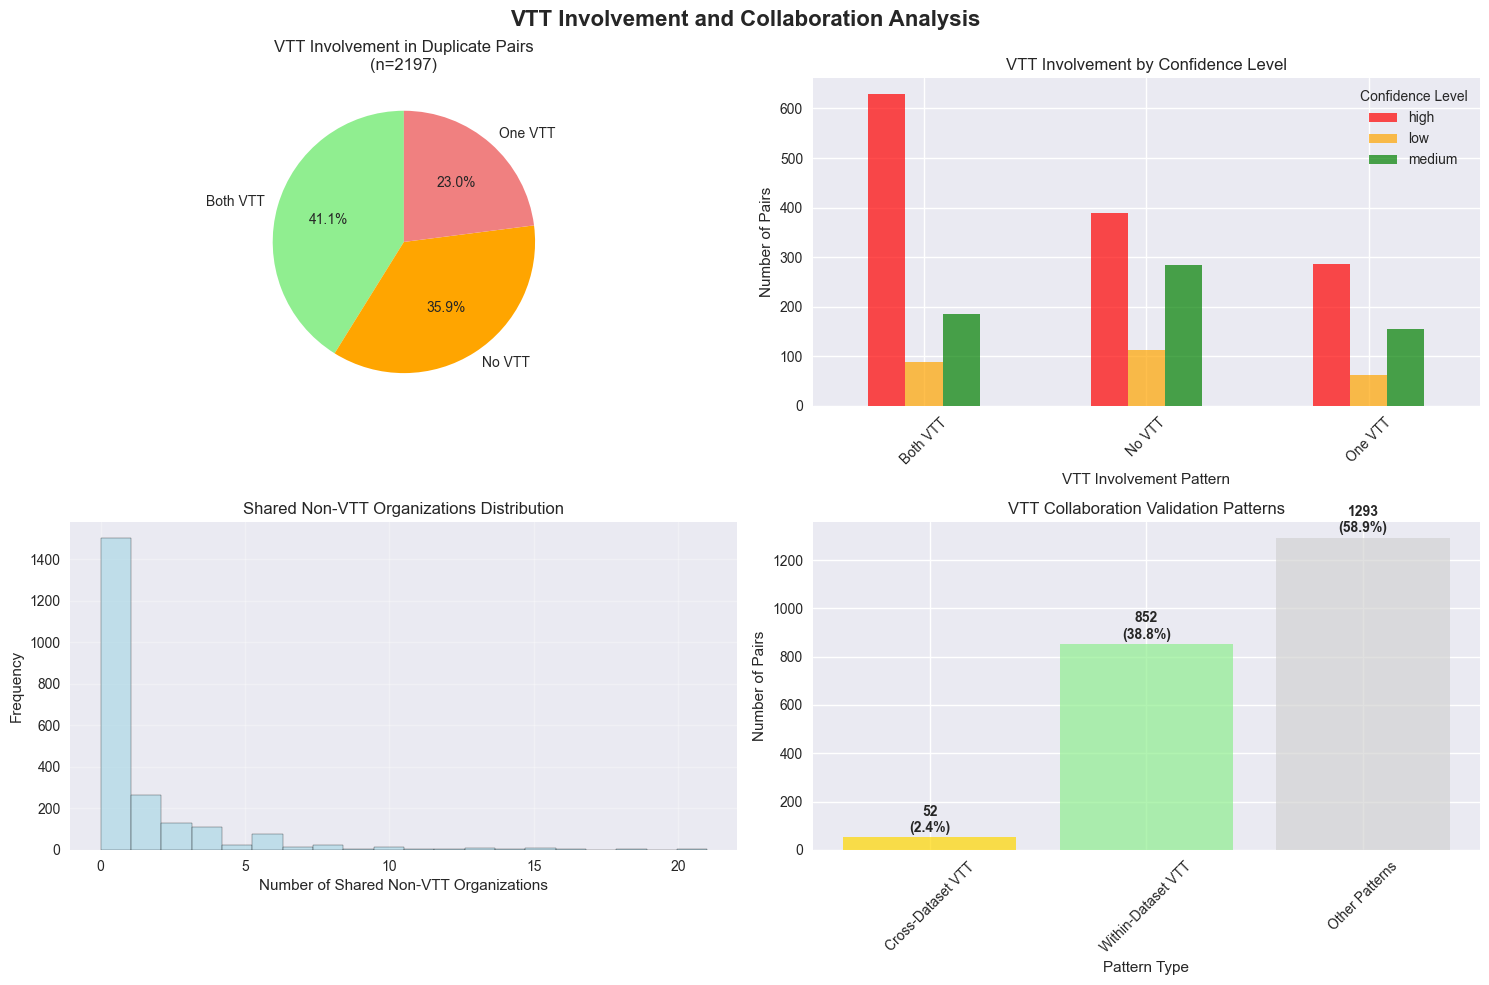

📊 VTT Involvement Statistics:
   • Both innovations have VTT: 904 (41.1%)
   • At least one has VTT: 1409 (64.1%)
   • Cross-dataset VTT validation: 52 pairs
   • Average shared non-VTT orgs: 1.9


In [28]:
# VTT involvement analysis
df_duplicates["both_have_vtt"] = df_duplicates["has_vtt_1"] & df_duplicates["has_vtt_2"]
df_duplicates["either_has_vtt"] = (
    df_duplicates["has_vtt_1"] | df_duplicates["has_vtt_2"]
)
df_duplicates["vtt_involvement_pattern"] = df_duplicates.apply(
    lambda row: "Both VTT"
    if row["both_have_vtt"]
    else "One VTT"
    if row["either_has_vtt"]
    else "No VTT",
    axis=1,
)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(
    "VTT Involvement and Collaboration Analysis", fontsize=16, fontweight="bold"
)

# 1. VTT involvement distribution
vtt_pattern_counts = df_duplicates["vtt_involvement_pattern"].value_counts()
axes[0, 0].pie(
    vtt_pattern_counts.values,
    labels=vtt_pattern_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=["lightgreen", "orange", "lightcoral"],
)
axes[0, 0].set_title(f"VTT Involvement in Duplicate Pairs\n(n={len(df_duplicates)})")

# 2. VTT involvement by confidence
vtt_conf_crosstab = pd.crosstab(
    df_duplicates["vtt_involvement_pattern"], df_duplicates["confidence_level"]
)
vtt_conf_crosstab.plot(
    kind="bar", ax=axes[0, 1], color=["red", "orange", "green"], alpha=0.7
)
axes[0, 1].set_title("VTT Involvement by Confidence Level")
axes[0, 1].set_xlabel("VTT Involvement Pattern")
axes[0, 1].set_ylabel("Number of Pairs")
axes[0, 1].legend(title="Confidence Level")
axes[0, 1].tick_params(axis="x", rotation=45)

# 3. Non-VTT organization sharing
axes[1, 0].hist(
    df_duplicates["shared_non_vtt_orgs_count"],
    bins=20,
    alpha=0.7,
    color="lightblue",
    edgecolor="black",
)
axes[1, 0].set_title("Shared Non-VTT Organizations Distribution")
axes[1, 0].set_xlabel("Number of Shared Non-VTT Organizations")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].grid(True, alpha=0.3)

# 4. VTT collaboration validation (cross-dataset + VTT involvement)
df_duplicates["is_cross_dataset"] = (
    df_duplicates["origin_1"] != df_duplicates["origin_2"]
)
cross_vtt = df_duplicates[
    df_duplicates["is_cross_dataset"] & df_duplicates["both_have_vtt"]
]
within_vtt = df_duplicates[
    ~df_duplicates["is_cross_dataset"] & df_duplicates["both_have_vtt"]
]

collaboration_data = {
    "Cross-Dataset VTT": len(cross_vtt),
    "Within-Dataset VTT": len(within_vtt),
    "Other Patterns": len(df_duplicates) - len(cross_vtt) - len(within_vtt),
}

axes[1, 1].bar(
    collaboration_data.keys(),
    collaboration_data.values(),
    color=["gold", "lightgreen", "lightgray"],
    alpha=0.7,
)
axes[1, 1].set_title("VTT Collaboration Validation Patterns")
axes[1, 1].set_xlabel("Pattern Type")
axes[1, 1].set_ylabel("Number of Pairs")
axes[1, 1].tick_params(axis="x", rotation=45)

# Add percentage labels
for i, (label, count) in enumerate(collaboration_data.items()):
    axes[1, 1].text(
        i,
        count + 10,
        f"{count}\n({count / total_pairs * 100:.1f}%)",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

# VTT involvement statistics
print("📊 VTT Involvement Statistics:")
print(
    f"   • Both innovations have VTT: {len(df_duplicates[df_duplicates['both_have_vtt']])} ({len(df_duplicates[df_duplicates['both_have_vtt']]) / total_pairs * 100:.1f}%)"
)
print(
    f"   • At least one has VTT: {len(df_duplicates[df_duplicates['either_has_vtt']])} ({len(df_duplicates[df_duplicates['either_has_vtt']]) / total_pairs * 100:.1f}%)"
)
print(f"   • Cross-dataset VTT validation: {len(cross_vtt)} pairs")
print(
    f"   • Average shared non-VTT orgs: {df_duplicates['shared_non_vtt_orgs_count'].mean():.1f}"
)

# 7. Cross-Platform and Multilingual Analysis

Analyze cross-platform mentions and potential multilingual variants.



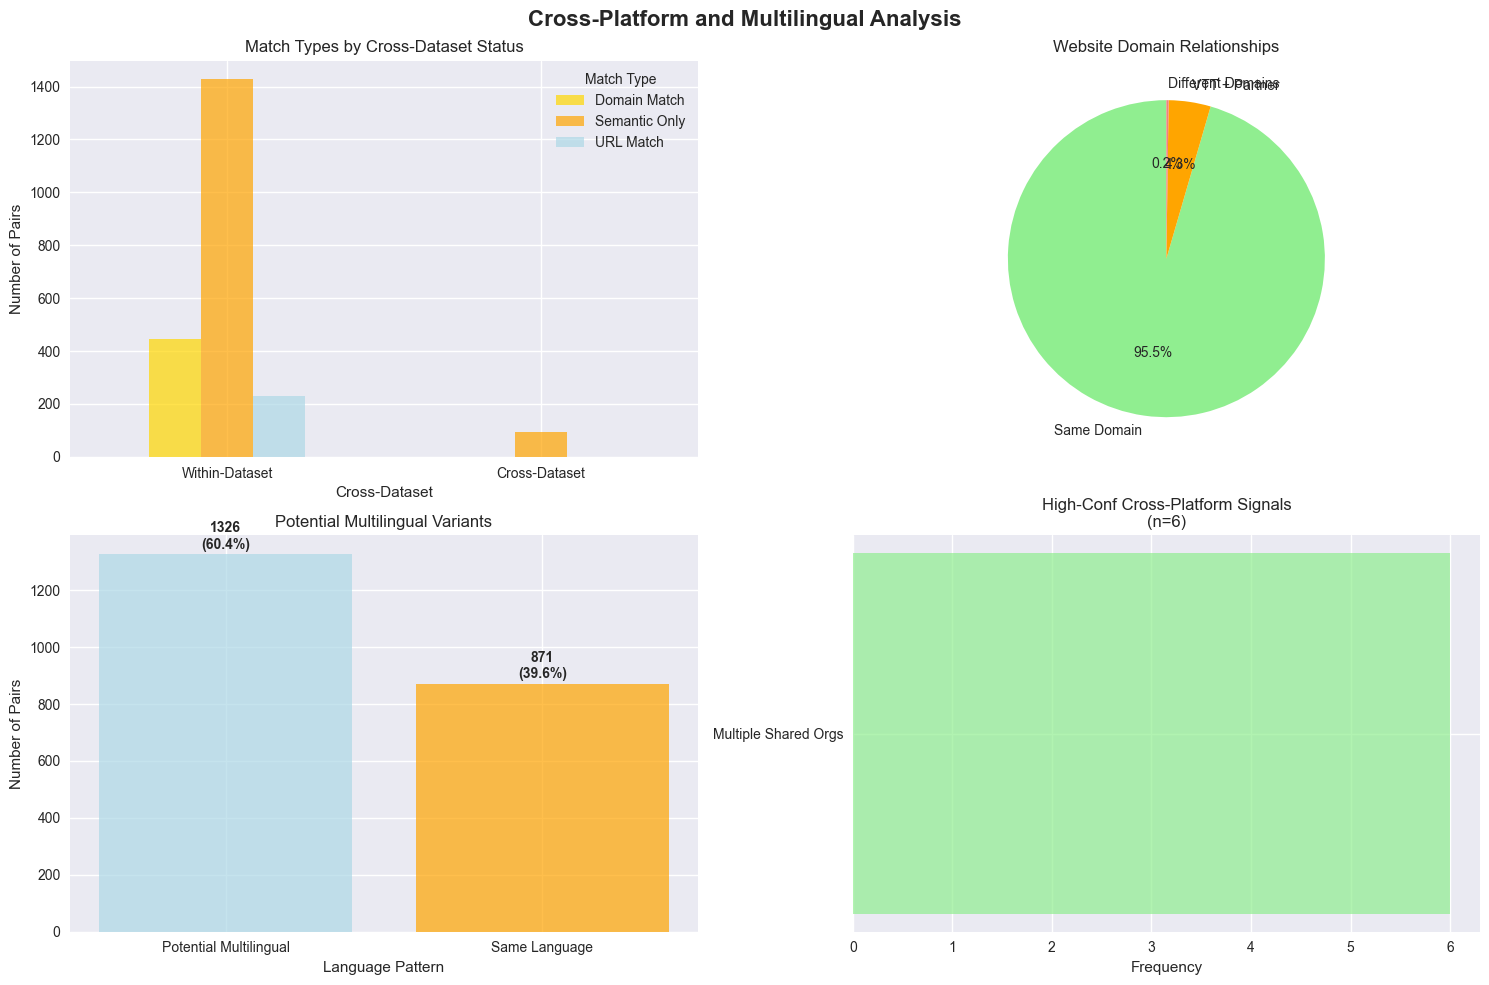

📊 Cross-Platform and Multilingual Statistics:
   • Cross-dataset pairs: 94 (4.3%)
   • High-confidence cross-platform: 6 pairs
   • Potential multilingual variants: 1326 pairs
   • Same domain pairs: 2098 pairs


In [29]:
# Cross-platform and multilingual analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Cross-Platform and Multilingual Analysis", fontsize=16, fontweight="bold")

# 1. Cross-dataset enhanced breakdown
cross_dataset_counts = df_duplicates["is_cross_dataset"].value_counts()
match_type_cross = (
    df_duplicates.groupby(["is_cross_dataset", "match_type_category"])
    .size()
    .unstack(fill_value=0)
)

match_type_cross.plot(
    kind="bar", ax=axes[0, 0], color=["gold", "orange", "lightblue"], alpha=0.7
)
axes[0, 0].set_title("Match Types by Cross-Dataset Status")
axes[0, 0].set_xlabel("Cross-Dataset")
axes[0, 0].set_xticklabels(["Within-Dataset", "Cross-Dataset"], rotation=0)
axes[0, 0].set_ylabel("Number of Pairs")
axes[0, 0].legend(title="Match Type")

# 2. Website domain analysis
domain_pairs = []
for _, row in df_duplicates.iterrows():
    domain1 = row["website_domain_1"] or "Unknown"
    domain2 = row["website_domain_2"] or "Unknown"
    if domain1 == domain2:
        domain_pairs.append("Same Domain")
    elif "vtt" in domain1.lower() or "vtt" in domain2.lower():
        domain_pairs.append("VTT + Partner")
    else:
        domain_pairs.append("Different Domains")

df_duplicates["domain_relationship"] = domain_pairs
domain_rel_counts = pd.Series(domain_pairs).value_counts()

axes[0, 1].pie(
    domain_rel_counts.values,
    labels=domain_rel_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=["lightgreen", "orange", "lightcoral"],
)
axes[0, 1].set_title("Website Domain Relationships")


# 3. Potential multilingual detection (name similarity analysis)
def are_potentially_multilingual(name1, name2):
    """Simple heuristic to detect potential multilingual variants"""
    if not name1 or not name2:
        return False

    # Remove common suffixes and prefixes
    clean1 = name1.lower().replace("project", "").replace("projekti", "").strip()
    clean2 = name2.lower().replace("project", "").replace("projekti", "").strip()

    # Check for partial matches or similar structure
    if len(clean1) > 3 and len(clean2) > 3:
        # Jaccard similarity of words
        words1 = set(clean1.split())
        words2 = set(clean2.split())
        if words1 and words2:
            jaccard = len(words1.intersection(words2)) / len(words1.union(words2))
            return jaccard > 0.3

    return False


multilingual_candidates = []
for _, row in df_duplicates.iterrows():
    if are_potentially_multilingual(row["name_1"], row["name_2"]):
        multilingual_candidates.append("Potential Multilingual")
    else:
        multilingual_candidates.append("Same Language")

df_duplicates["potential_multilingual"] = multilingual_candidates
multilingual_counts = pd.Series(multilingual_candidates).value_counts()

axes[1, 0].bar(
    multilingual_counts.index,
    multilingual_counts.values,
    color=["lightblue", "orange"],
    alpha=0.7,
)
axes[1, 0].set_title("Potential Multilingual Variants")
axes[1, 0].set_xlabel("Language Pattern")
axes[1, 0].set_ylabel("Number of Pairs")

# Add percentage labels
for i, (label, count) in enumerate(multilingual_counts.items()):
    axes[1, 0].text(
        i,
        count + 10,
        f"{count}\n({count / total_pairs * 100:.1f}%)",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

# 4. High-confidence cross-platform analysis
cross_platform_high = df_duplicates[
    (df_duplicates["is_cross_dataset"]) & (df_duplicates["confidence_level"] == "high")
]

cross_platform_signals = []
for _, row in cross_platform_high.iterrows():
    if row["url_match"]:
        cross_platform_signals.append("URL Match")
    elif row["domain_match"]:
        cross_platform_signals.append("Domain Match")
    elif row["shared_non_vtt_orgs_count"] > 1:
        cross_platform_signals.append("Multiple Shared Orgs")
    else:
        cross_platform_signals.append("Semantic + Some Context")

if cross_platform_signals:
    signal_counts = pd.Series(cross_platform_signals).value_counts()
    axes[1, 1].barh(
        range(len(signal_counts)), signal_counts.values, color="lightgreen", alpha=0.7
    )
    axes[1, 1].set_yticks(range(len(signal_counts)))
    axes[1, 1].set_yticklabels(signal_counts.index)
    axes[1, 1].set_title(
        f"High-Conf Cross-Platform Signals\n(n={len(cross_platform_high)})"
    )
    axes[1, 1].set_xlabel("Frequency")
else:
    axes[1, 1].text(
        0.5,
        0.5,
        "No high-confidence\ncross-platform pairs",
        ha="center",
        va="center",
        transform=axes[1, 1].transAxes,
    )
    axes[1, 1].set_title("High-Conf Cross-Platform Signals")

plt.tight_layout()
plt.show()

# Cross-platform statistics
print("📊 Cross-Platform and Multilingual Statistics:")
print(
    f"   • Cross-dataset pairs: {cross_dataset_counts[True]} ({cross_dataset_counts[True] / total_pairs * 100:.1f}%)"
)
print(f"   • High-confidence cross-platform: {len(cross_platform_high)} pairs")
print(
    f"   • Potential multilingual variants: {multilingual_counts.get('Potential Multilingual', 0)} pairs"
)
print(f"   • Same domain pairs: {domain_rel_counts.get('Same Domain', 0)} pairs")

# 8. Enhanced Context Signal Analysis

Deep dive into URL, domain, and contextual signals effectiveness.


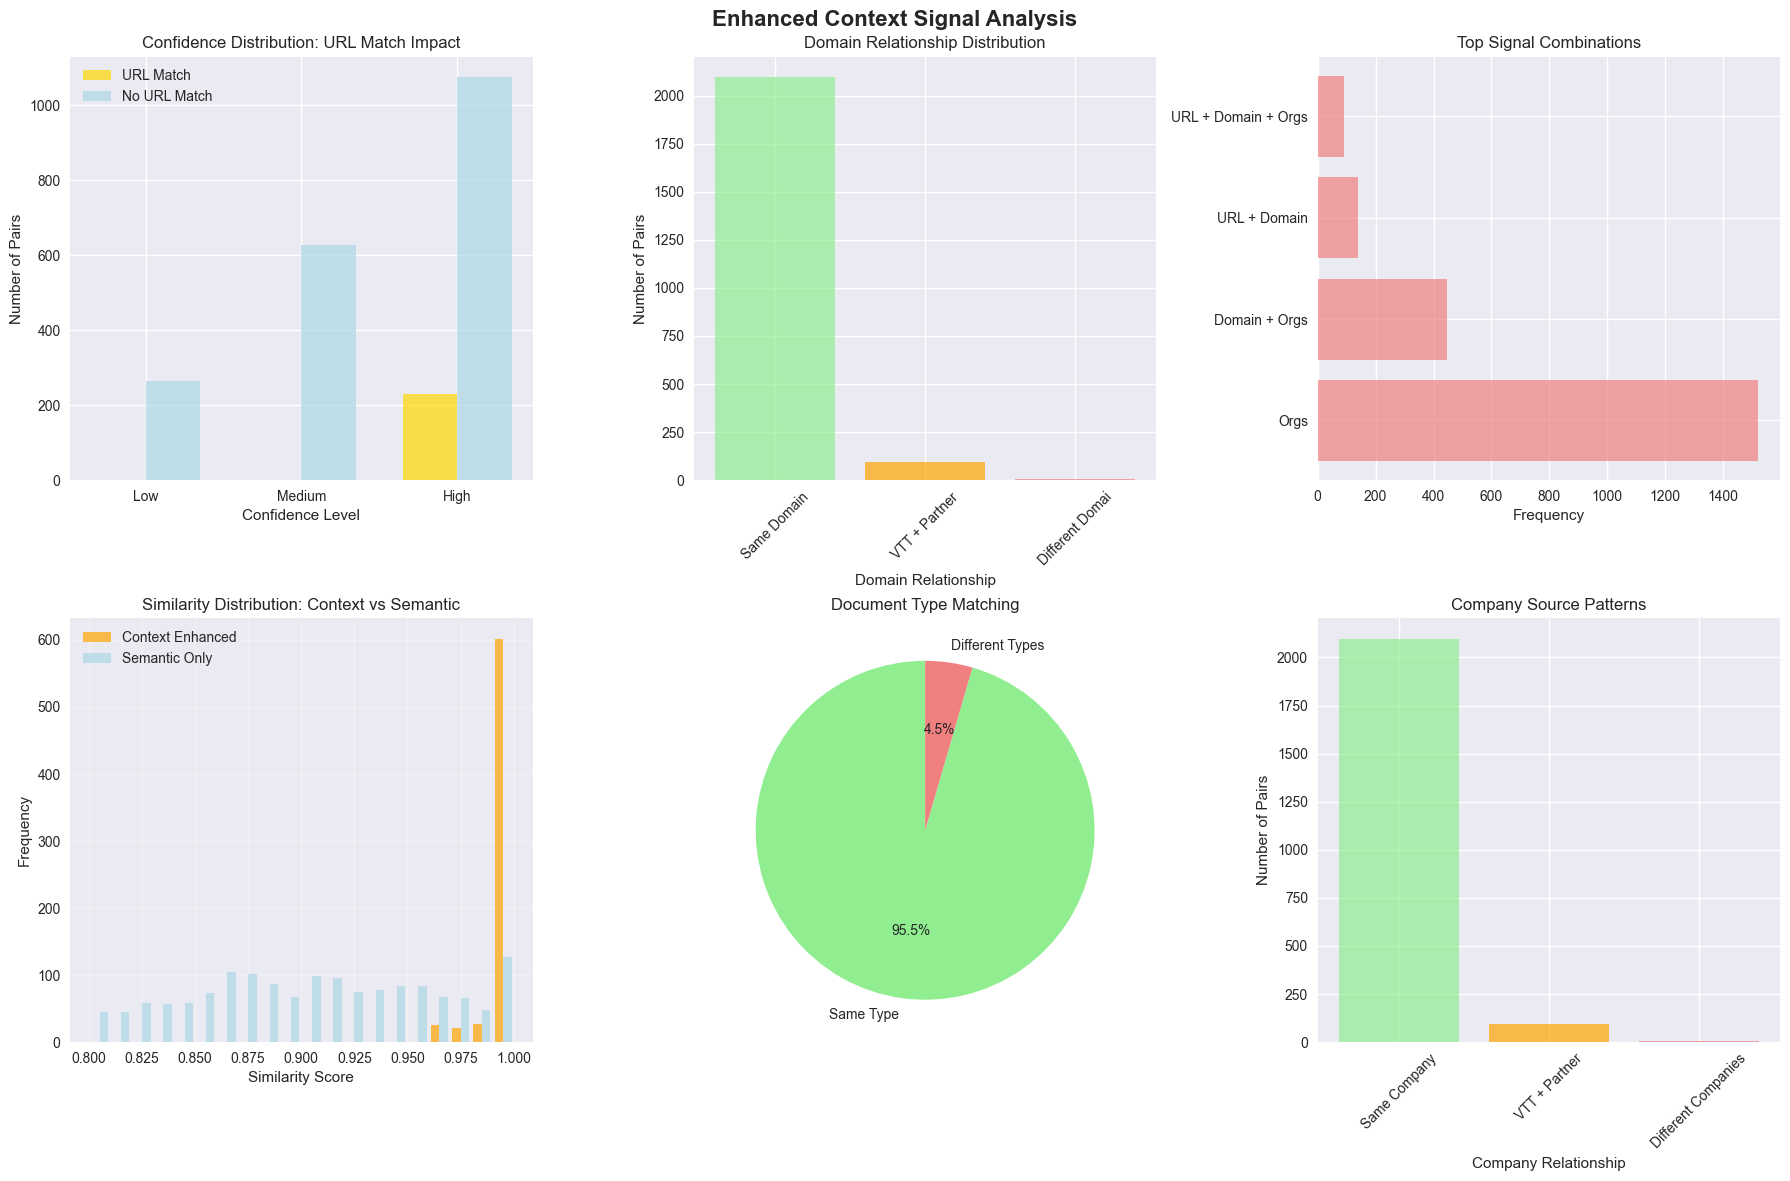

📊 Enhanced Context Signal Statistics:
   • URL matches: 230 pairs
   • Domain matches: 676 pairs
   • Context enhanced (URL or Domain): 676 pairs
   • Semantic only: 1521 pairs
   • Same document type: 2098 pairs
   • Same company source: 2098 pairs


In [31]:
# Enhanced context signal analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("Enhanced Context Signal Analysis", fontsize=16, fontweight="bold")

# 1. URL match impact on confidence
url_match_conf = df_duplicates[df_duplicates["url_match"]][
    "confidence_level"
].value_counts()
no_url_match_conf = df_duplicates[~df_duplicates["url_match"]][
    "confidence_level"
].value_counts()

x = np.arange(len(["low", "medium", "high"]))
width = 0.35

url_counts = [url_match_conf.get(level, 0) for level in ["low", "medium", "high"]]
no_url_counts = [no_url_match_conf.get(level, 0) for level in ["low", "medium", "high"]]

axes[0, 0].bar(
    x - width / 2, url_counts, width, label="URL Match", alpha=0.7, color="gold"
)
axes[0, 0].bar(
    x + width / 2,
    no_url_counts,
    width,
    label="No URL Match",
    alpha=0.7,
    color="lightblue",
)
axes[0, 0].set_title("Confidence Distribution: URL Match Impact")
axes[0, 0].set_xlabel("Confidence Level")
axes[0, 0].set_ylabel("Number of Pairs")
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(["Low", "Medium", "High"])
axes[0, 0].legend()

# 2. Domain match effectiveness
domain_types = df_duplicates["domain_relationship"].value_counts()
axes[0, 1].bar(
    range(len(domain_types)),
    domain_types.values,
    color=["lightgreen", "orange", "lightcoral"],
    alpha=0.7,
)
axes[0, 1].set_title("Domain Relationship Distribution")
axes[0, 1].set_xlabel("Domain Relationship")
axes[0, 1].set_ylabel("Number of Pairs")
axes[0, 1].set_xticks(range(len(domain_types)))
axes[0, 1].set_xticklabels([label[:15] for label in domain_types.index], rotation=45)

# 3. Context signal combination effectiveness
signal_combinations = []
for _, row in df_duplicates.iterrows():
    signals = []
    if row["url_match"]:
        signals.append("URL")
    if row["domain_match"]:
        signals.append("Domain")
    if row["shared_non_vtt_orgs_count"] > 0:
        signals.append("Orgs")

    if not signals:
        signal_combinations.append("Semantic Only")
    else:
        signal_combinations.append(" + ".join(signals))

df_duplicates["signal_combination"] = signal_combinations
combo_counts = pd.Series(signal_combinations).value_counts().head(8)

axes[0, 2].barh(
    range(len(combo_counts)), combo_counts.values, color="lightcoral", alpha=0.7
)
axes[0, 2].set_yticks(range(len(combo_counts)))
axes[0, 2].set_yticklabels(
    [combo[:20] + "..." if len(combo) > 20 else combo for combo in combo_counts.index]
)
axes[0, 2].set_title("Top Signal Combinations")
axes[0, 2].set_xlabel("Frequency")

# 4. Similarity score enhancement by context
context_enhanced = df_duplicates[
    df_duplicates["url_match"] | df_duplicates["domain_match"]
]
semantic_only = df_duplicates[
    ~df_duplicates["url_match"] & ~df_duplicates["domain_match"]
]

axes[1, 0].hist(
    [context_enhanced["similarity_score"], semantic_only["similarity_score"]],
    bins=20,
    alpha=0.7,
    label=["Context Enhanced", "Semantic Only"],
    color=["orange", "lightblue"],
)
axes[1, 0].set_title("Similarity Distribution: Context vs Semantic")
axes[1, 0].set_xlabel("Similarity Score")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Document type matching analysis
doc_type_matches = []
for _, row in df_duplicates.iterrows():
    type1 = row["document_type_1"] or "Unknown"
    type2 = row["document_type_2"] or "Unknown"
    if type1 == type2:
        doc_type_matches.append("Same Type")
    else:
        doc_type_matches.append("Different Types")

df_duplicates["doc_type_match"] = doc_type_matches
doc_type_counts = pd.Series(doc_type_matches).value_counts()

axes[1, 1].pie(
    doc_type_counts.values,
    labels=doc_type_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=["lightgreen", "lightcoral"],
)
axes[1, 1].set_title("Document Type Matching")

# 6. Company source consistency
company_matches = []
for _, row in df_duplicates.iterrows():
    comp1 = row["company_name_1"] or "Unknown"
    comp2 = row["company_name_2"] or "Unknown"
    if comp1 == comp2:
        company_matches.append("Same Company")
    elif "VTT" in comp1 or "VTT" in comp2:
        company_matches.append("VTT + Partner")
    else:
        company_matches.append("Different Companies")

df_duplicates["company_match"] = company_matches
company_counts = pd.Series(company_matches).value_counts()

axes[1, 2].bar(
    company_counts.index,
    company_counts.values,
    color=["lightgreen", "orange", "lightcoral"],
    alpha=0.7,
)
axes[1, 2].set_title("Company Source Patterns")
axes[1, 2].set_xlabel("Company Relationship")
axes[1, 2].set_ylabel("Number of Pairs")
axes[1, 2].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

# Context signal statistics
print("📊 Enhanced Context Signal Statistics:")
print(f"   • URL matches: {len(df_duplicates[df_duplicates['url_match']])} pairs")
print(f"   • Domain matches: {len(df_duplicates[df_duplicates['domain_match']])} pairs")
print(f"   • Context enhanced (URL or Domain): {len(context_enhanced)} pairs")
print(f"   • Semantic only: {len(semantic_only)} pairs")
print(f"   • Same document type: {doc_type_counts.get('Same Type', 0)} pairs")
print(f"   • Same company source: {company_counts.get('Same Company', 0)} pairs")

# 9. Innovation Hotspot Analysis with Context

Enhanced hotspot analysis including context information.


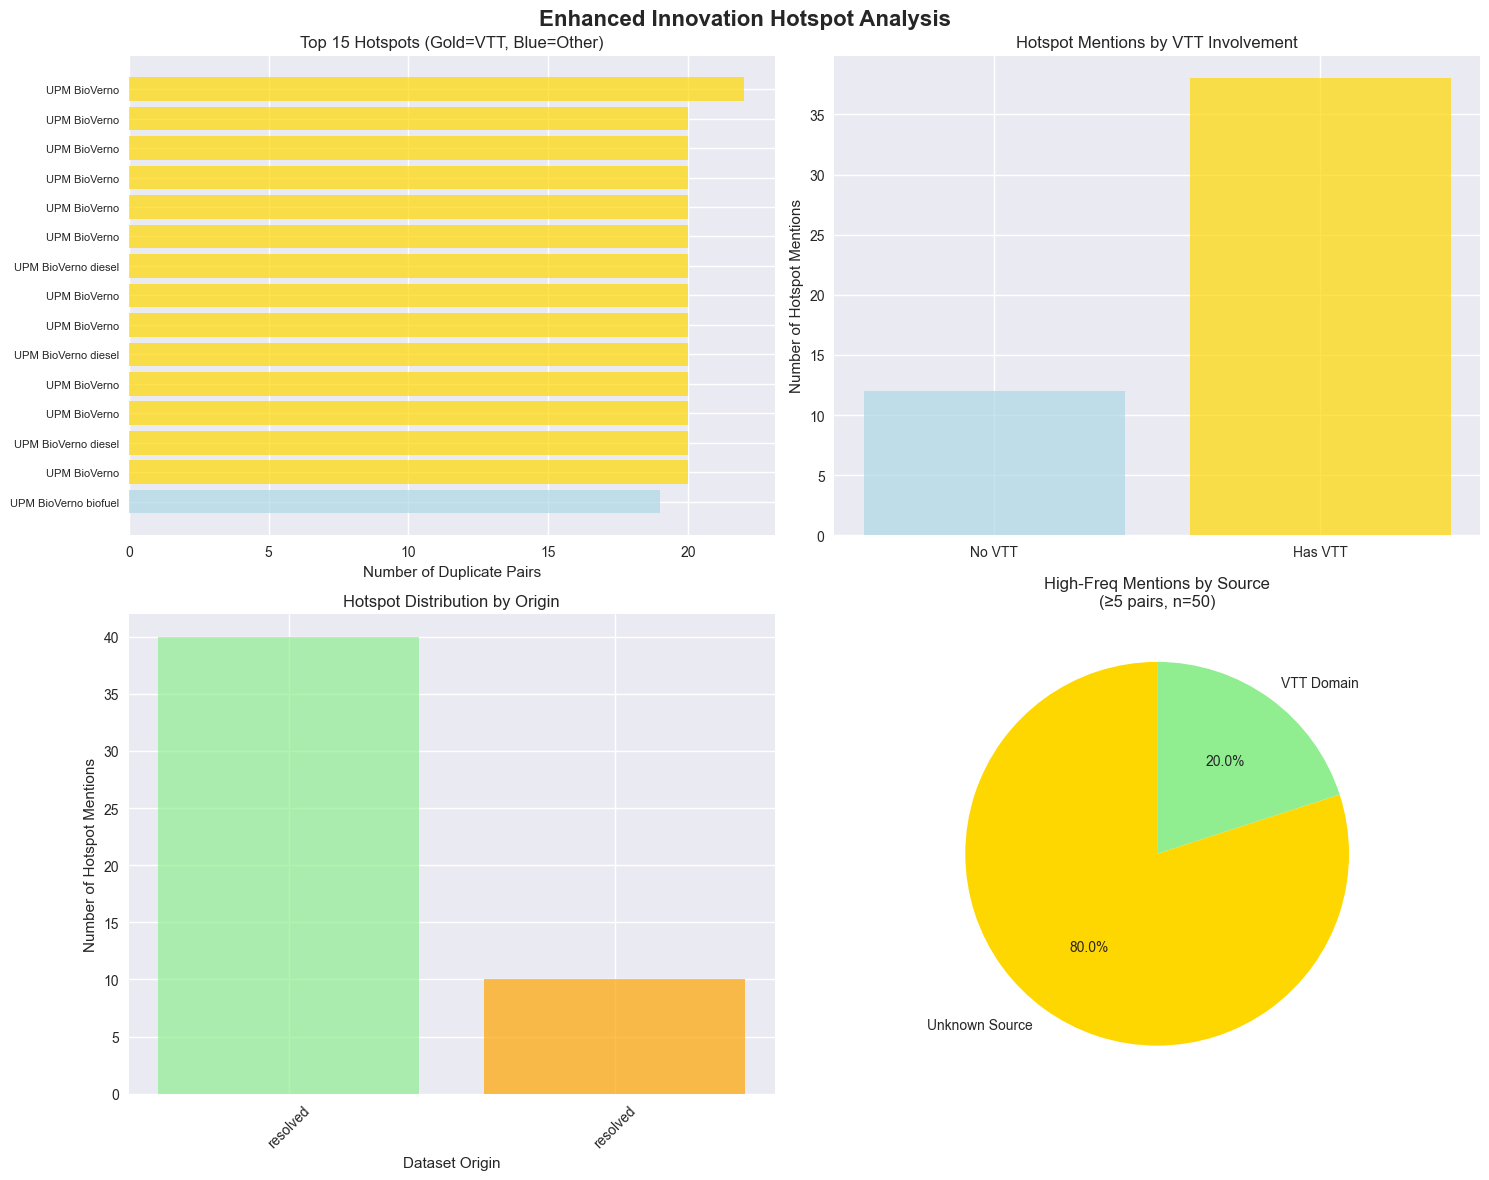

🔥 Enhanced Innovation Hotspot Analysis:
 1. UPM BioVerno
    └─ 🏢 VTT | resolved | Domain: Unknown | Pairs: 22

 2. UPM BioVerno
    └─ 🏢 VTT | resolved | Domain: Unknown | Pairs: 20

 3. UPM BioVerno
    └─ 🏢 VTT | resolved | Domain: Unknown | Pairs: 20

 4. UPM BioVerno
    └─ 🏢 VTT | resolved | Domain: Unknown | Pairs: 20

 5. UPM BioVerno
    └─ 🏢 VTT | resolved | Domain: Unknown | Pairs: 20

 6. UPM BioVerno
    └─ 🏢 VTT | resolved | Domain: Unknown | Pairs: 20

 7. UPM BioVerno diesel
    └─ 🏢 VTT | resolved | Domain: Unknown | Pairs: 20

 8. UPM BioVerno
    └─ 🏢 VTT | resolved | Domain: Unknown | Pairs: 20

 9. UPM BioVerno
    └─ 🏢 VTT | resolved | Domain: Unknown | Pairs: 20

10. UPM BioVerno diesel
    └─ 🏢 VTT | resolved | Domain: Unknown | Pairs: 20

11. UPM BioVerno
    └─ 🏢 VTT | resolved | Domain: Unknown | Pairs: 20

12. UPM BioVerno
    └─ 🏢 VTT | resolved | Domain: Unknown | Pairs: 20

13. UPM BioVerno diesel
    └─ 🏢 VTT | resolved | Domain: Unknown | Pairs: 20

14.

In [35]:
# Enhanced innovation hotspot analysis
all_mention_ids = list(df_duplicates["mention_id_1"]) + list(
    df_duplicates["mention_id_2"]
)
mention_counts = Counter(all_mention_ids)

# Create enhanced DataFrame for hotspot analysis
hotspot_data = []
for mention_id, count in mention_counts.most_common(50):
    # Find details for this mention from either position
    row_data = None
    if not df_duplicates[df_duplicates["mention_id_1"] == mention_id].empty:
        row_data = df_duplicates[df_duplicates["mention_id_1"] == mention_id].iloc[0]
        prefix = "1"
    elif not df_duplicates[df_duplicates["mention_id_2"] == mention_id].empty:
        row_data = df_duplicates[df_duplicates["mention_id_2"] == mention_id].iloc[0]
        prefix = "2"

    if row_data is not None:
        hotspot_data.append(
            {
                "mention_id": mention_id,
                "name": row_data[f"name_{prefix}"],
                "origin": row_data[f"origin_{prefix}"],
                "has_vtt": row_data[f"has_vtt_{prefix}"],
                "website_domain": row_data[f"website_domain_{prefix}"],
                "document_type": row_data[f"document_type_{prefix}"],
                "company_name": row_data[f"company_name_{prefix}"],
                "pair_count": count,
            }
        )

df_hotspots = pd.DataFrame(hotspot_data)

# Enhanced visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Enhanced Innovation Hotspot Analysis", fontsize=16, fontweight="bold")

# 1. Top 15 hotspots with VTT indication
top_15 = df_hotspots.head(15)
colors = ["gold" if has_vtt else "lightblue" for has_vtt in top_15["has_vtt"]]

axes[0, 0].barh(range(len(top_15)), top_15["pair_count"], color=colors, alpha=0.7)
axes[0, 0].set_yticks(range(len(top_15)))
axes[0, 0].set_yticklabels(
    [f"{name[:25]}..." if len(name) > 25 else name for name in top_15["name"]],
    fontsize=8,
)
axes[0, 0].set_xlabel("Number of Duplicate Pairs")
axes[0, 0].set_title("Top 15 Hotspots (Gold=VTT, Blue=Other)")
axes[0, 0].invert_yaxis()

# 2. Hotspots by VTT involvement
vtt_hotspots = (
    df_hotspots.groupby("has_vtt")
    .agg({"pair_count": ["count", "mean", "max"]})
    .round(2)
)

vtt_counts = df_hotspots["has_vtt"].value_counts()
axes[0, 1].bar(
    ["No VTT", "Has VTT"],
    [vtt_counts.get(False, 0), vtt_counts.get(True, 0)],
    color=["lightblue", "gold"],
    alpha=0.7,
)
axes[0, 1].set_title("Hotspot Mentions by VTT Involvement")
axes[0, 1].set_ylabel("Number of Hotspot Mentions")

# 3. Hotspots by origin with enhanced info
origin_hotspots = (
    df_hotspots.groupby("origin")
    .agg({"pair_count": ["count", "mean", "max"], "has_vtt": "sum"})
    .round(2)
)

origin_counts = df_hotspots["origin"].value_counts()
axes[1, 0].bar(
    range(len(origin_counts)),
    origin_counts.values,
    color=["lightgreen", "orange"],
    alpha=0.7,
)
axes[1, 0].set_title("Hotspot Distribution by Origin")
axes[1, 0].set_xlabel("Dataset Origin")
axes[1, 0].set_ylabel("Number of Hotspot Mentions")
axes[1, 0].set_xticks(range(len(origin_counts)))
axes[1, 0].set_xticklabels(
    [label.split("_")[-1] for label in origin_counts.index], rotation=45
)

# 4. High-frequency mentions with context
high_freq = df_hotspots[df_hotspots["pair_count"] >= 5]
if len(high_freq) > 0:
    context_sources = []
    for _, row in high_freq.iterrows():
        if row["website_domain"] and "vtt" in row["website_domain"].lower():
            context_sources.append("VTT Domain")
        elif row["company_name"] and row["company_name"] != "Unknown":
            context_sources.append("Partner Company")
        else:
            context_sources.append("Unknown Source")

    context_counts = pd.Series(context_sources).value_counts()
    axes[1, 1].pie(
        context_counts.values,
        labels=context_counts.index,
        autopct="%1.1f%%",
        startangle=90,
        colors=["gold", "lightgreen", "lightgray"],
    )
    axes[1, 1].set_title(
        f"High-Freq Mentions by Source\n(≥5 pairs, n={len(high_freq)})"
    )
else:
    axes[1, 1].text(
        0.5,
        0.5,
        "No high-frequency\nmentions found",
        ha="center",
        va="center",
        transform=axes[1, 1].transAxes,
    )
    axes[1, 1].set_title("High-Frequency Mentions")

plt.tight_layout()
plt.show()

# Enhanced hotspot statistics
print("🔥 Enhanced Innovation Hotspot Analysis:")
print("=" * 80)
for i, row in df_hotspots.head(15).iterrows():
    name_display = row["name"][:50] + "..." if len(row["name"]) > 50 else row["name"]
    vtt_indicator = "🏢 VTT" if row["has_vtt"] else "🏭 Partner"
    domain_info = row["website_domain"] or "Unknown"
    print(f"{i + 1:2d}. {name_display}")
    print(
        f"    └─ {vtt_indicator} | {row['origin'].split('_')[-1]} | Domain: {domain_info[:20]} | Pairs: {row['pair_count']}"
    )
    print()

print(f"📊 Enhanced Hotspot Statistics:")
print(f"   • Total unique mentions in pairs: {len(df_hotspots)}")
print(
    f"   • VTT-involved hotspots: {len(df_hotspots[df_hotspots['has_vtt']])} ({len(df_hotspots[df_hotspots['has_vtt']]) / len(df_hotspots) * 100:.1f}%)"
)
print(f"   • High-frequency mentions (≥5 pairs): {len(high_freq)}")
print(f"   • Maximum pairs for single mention: {df_hotspots['pair_count'].max()}")

# 10. Perfect Matches and Context Validation

Analysis of perfect matches with enhanced context validation.


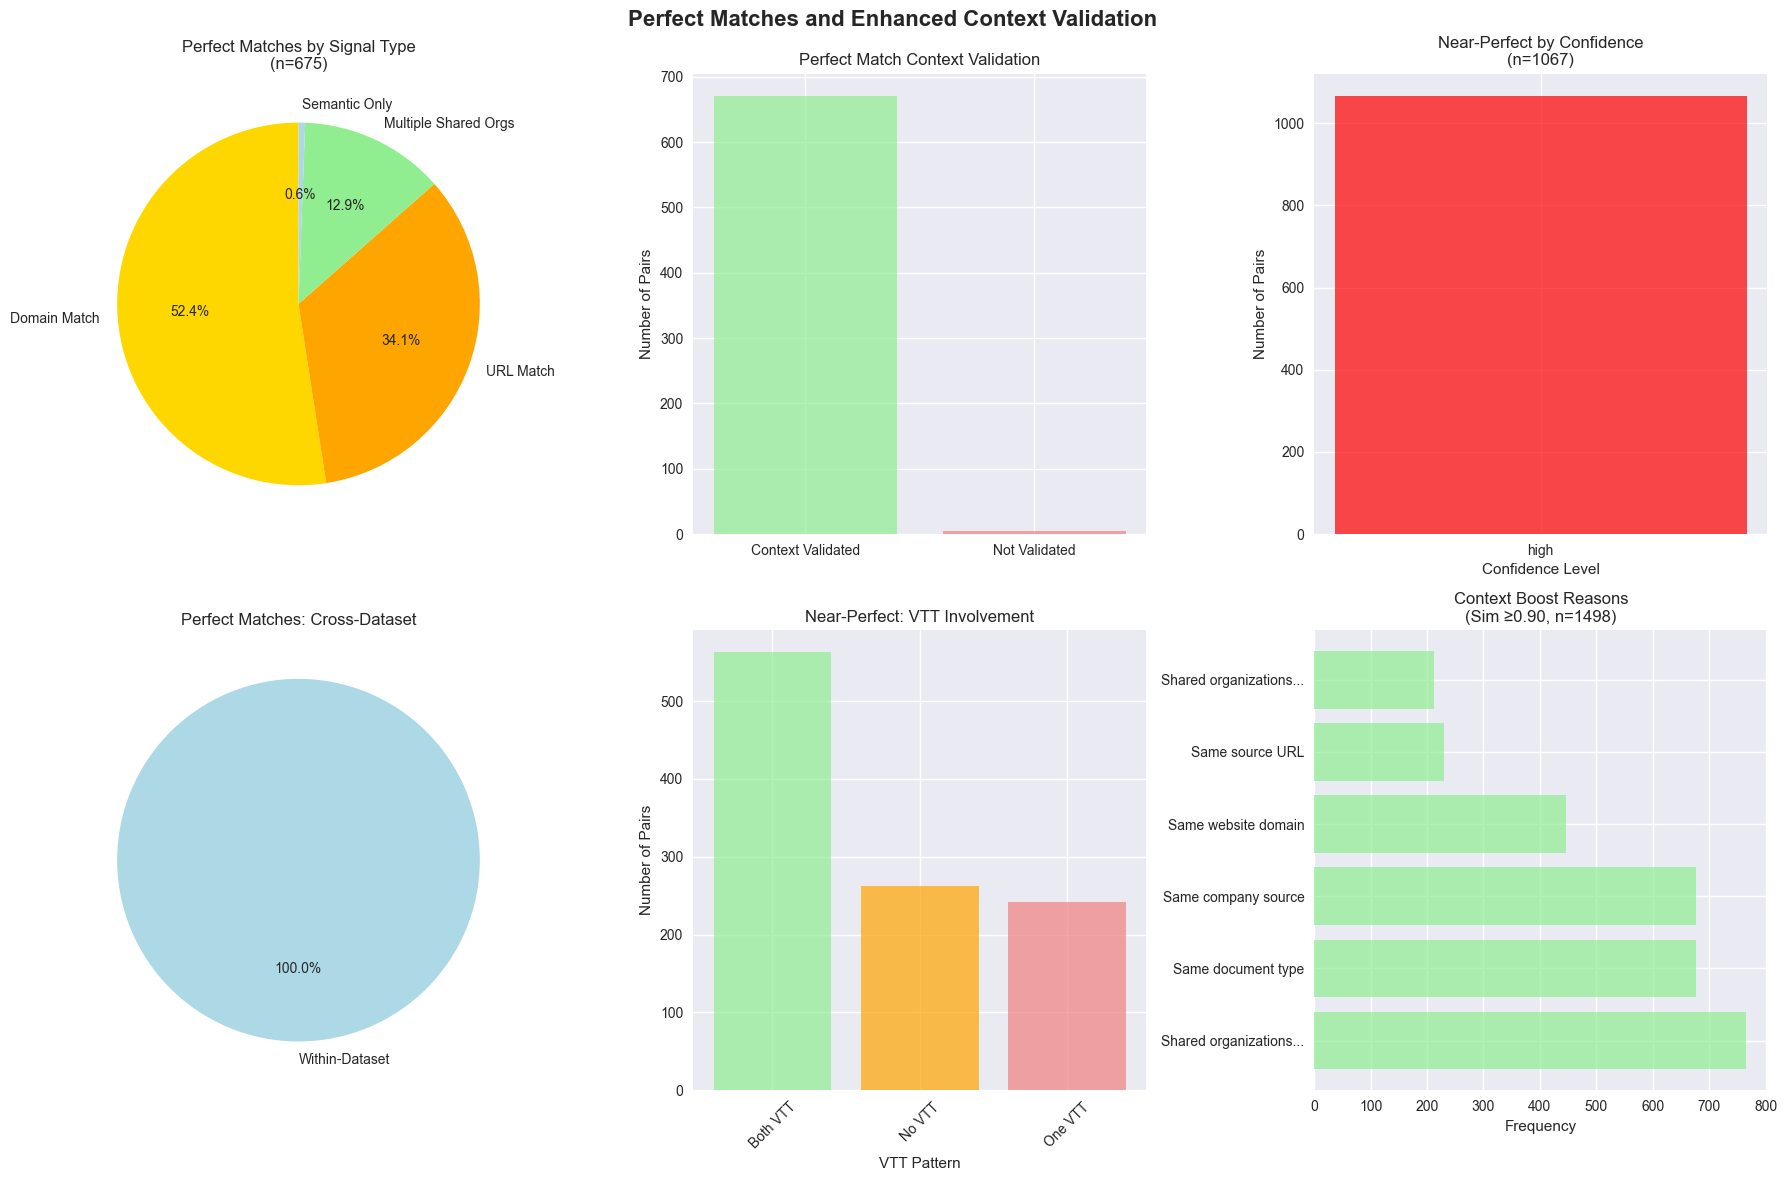

✨ Enhanced Perfect and Near-Perfect Matches Analysis:
🎯 Perfect Matches (≥0.999): 675 pairs
   • With exact name matches: 137 (20.3%)
   • Context validated: 671 (99.4%)
   • Cross-dataset: 0 (0.0%)
   • With VTT involvement: 574 pairs

🎯 Near-Perfect Matches (≥0.95): 1067 pairs
   • With exact name matches: 294 (27.6%)
   • High confidence: 1067 (100.0%)
   • Cross-dataset: 1 pairs
   • With VTT involvement: 805 pairs


In [36]:
# Enhanced perfect matches analysis
df_perfect = df_duplicates[df_duplicates["similarity_score"] >= 0.999]
df_near_perfect = df_duplicates[df_duplicates["similarity_score"] >= 0.95]

# Enhanced exact name matching
df_perfect["names_exact_match"] = (
    df_perfect["name_1"].str.lower().str.strip()
    == df_perfect["name_2"].str.lower().str.strip()
)
df_near_perfect["names_exact_match"] = (
    df_near_perfect["name_1"].str.lower().str.strip()
    == df_near_perfect["name_2"].str.lower().str.strip()
)

# Context validation for perfect matches
if len(df_perfect) > 0:
    df_perfect["context_validated"] = (
        df_perfect["url_match"]
        | df_perfect["domain_match"]
        | (df_perfect["shared_non_vtt_orgs_count"] > 1)
    )

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(
    "Perfect Matches and Enhanced Context Validation", fontsize=16, fontweight="bold"
)

# 1. Perfect matches by context signals
if len(df_perfect) > 0:
    perfect_signals = []
    for _, row in df_perfect.iterrows():
        if row["url_match"]:
            perfect_signals.append("URL Match")
        elif row["domain_match"]:
            perfect_signals.append("Domain Match")
        elif row["shared_non_vtt_orgs_count"] > 1:
            perfect_signals.append("Multiple Shared Orgs")
        else:
            perfect_signals.append("Semantic Only")

    signal_counts = pd.Series(perfect_signals).value_counts()
    axes[0, 0].pie(
        signal_counts.values,
        labels=signal_counts.index,
        autopct="%1.1f%%",
        startangle=90,
        colors=["gold", "orange", "lightgreen", "lightblue"],
    )
    axes[0, 0].set_title(f"Perfect Matches by Signal Type\n(n={len(df_perfect)})")
else:
    axes[0, 0].text(
        0.5,
        0.5,
        "No perfect matches\nfound",
        ha="center",
        va="center",
        transform=axes[0, 0].transAxes,
        fontsize=12,
    )
    axes[0, 0].set_title("Perfect Matches (≥0.999)")

# 2. Context validation effectiveness
validation_data = {
    "Context Validated": len(df_perfect[df_perfect["context_validated"]])
    if len(df_perfect) > 0
    else 0,
    "Not Validated": len(df_perfect[~df_perfect["context_validated"]])
    if len(df_perfect) > 0
    else 0,
}

axes[0, 1].bar(
    validation_data.keys(),
    validation_data.values(),
    color=["lightgreen", "lightcoral"],
    alpha=0.7,
)
axes[0, 1].set_title("Perfect Match Context Validation")
axes[0, 1].set_ylabel("Number of Pairs")

# 3. Near-perfect by confidence enhancement
near_perfect_conf = df_near_perfect["confidence_level"].value_counts()
axes[0, 2].bar(
    near_perfect_conf.index,
    near_perfect_conf.values,
    color=["red", "orange", "green"],
    alpha=0.7,
)
axes[0, 2].set_title(f"Near-Perfect by Confidence\n(n={len(df_near_perfect)})")
axes[0, 2].set_xlabel("Confidence Level")
axes[0, 2].set_ylabel("Number of Pairs")

# 4. Cross-dataset perfect matches
if len(df_perfect) > 0:
    perfect_cross = df_perfect["is_cross_dataset"].value_counts()

    # Handle dynamic length and label mapping
    cross_labels_map = {False: "Within-Dataset", True: "Cross-Dataset"}
    cross_labels = [cross_labels_map.get(k, str(k)) for k in perfect_cross.index]

    axes[1, 0].pie(
        perfect_cross.values,
        labels=cross_labels,
        autopct="%1.1f%%",
        startangle=90,
        colors=["lightblue", "orange"][: len(perfect_cross)],
    )
    axes[1, 0].set_title("Perfect Matches: Cross-Dataset")
else:
    axes[1, 0].text(
        0.5,
        0.5,
        "No perfect matches\nto analyze",
        ha="center",
        va="center",
        transform=axes[1, 0].transAxes,
    )


# 5. VTT involvement in near-perfect matches
near_perfect_vtt = df_near_perfect["vtt_involvement_pattern"].value_counts()
axes[1, 1].bar(
    range(len(near_perfect_vtt)),
    near_perfect_vtt.values,
    color=["lightgreen", "orange", "lightcoral"],
    alpha=0.7,
)
axes[1, 1].set_title("Near-Perfect: VTT Involvement")
axes[1, 1].set_xlabel("VTT Pattern")
axes[1, 1].set_ylabel("Number of Pairs")
axes[1, 1].set_xticks(range(len(near_perfect_vtt)))
axes[1, 1].set_xticklabels(near_perfect_vtt.index, rotation=45)

# 6. Context boost distribution in high similarity
high_sim_boost = df_duplicates[df_duplicates["similarity_score"] >= 0.90]
boost_reasons = []
for reasons in high_sim_boost["match_reasons"]:
    if reasons:
        boost_reasons.extend([r.strip() for r in reasons.split(",") if r.strip()])

if boost_reasons:
    boost_counts = pd.Series(boost_reasons).value_counts().head(6)
    axes[1, 2].barh(
        range(len(boost_counts)), boost_counts.values, color="lightgreen", alpha=0.7
    )
    axes[1, 2].set_yticks(range(len(boost_counts)))
    axes[1, 2].set_yticklabels(
        [r[:20] + "..." if len(r) > 20 else r for r in boost_counts.index]
    )
    axes[1, 2].set_title(f"Context Boost Reasons\n(Sim ≥0.90, n={len(high_sim_boost)})")
    axes[1, 2].set_xlabel("Frequency")
else:
    axes[1, 2].text(
        0.5,
        0.5,
        "No context boost\nreasons found",
        ha="center",
        va="center",
        transform=axes[1, 2].transAxes,
    )

plt.tight_layout()
plt.show()

# Enhanced perfect match statistics
print("✨ Enhanced Perfect and Near-Perfect Matches Analysis:")
print("=" * 70)

if len(df_perfect) > 0:
    print(f"🎯 Perfect Matches (≥0.999): {len(df_perfect)} pairs")
    print(
        f"   • With exact name matches: {df_perfect['names_exact_match'].sum()} ({df_perfect['names_exact_match'].mean() * 100:.1f}%)"
    )
    print(
        f"   • Context validated: {validation_data['Context Validated']} ({validation_data['Context Validated'] / len(df_perfect) * 100:.1f}%)"
    )
    print(
        f"   • Cross-dataset: {len(df_perfect[df_perfect['is_cross_dataset']])} ({len(df_perfect[df_perfect['is_cross_dataset']]) / len(df_perfect) * 100:.1f}%)"
    )
    print(
        f"   • With VTT involvement: {len(df_perfect[df_perfect['either_has_vtt']])} pairs"
    )
else:
    print("🎯 Perfect Matches (≥0.999): None found")

print(f"\n🎯 Near-Perfect Matches (≥0.95): {len(df_near_perfect)} pairs")
print(
    f"   • With exact name matches: {df_near_perfect['names_exact_match'].sum()} ({df_near_perfect['names_exact_match'].mean() * 100:.1f}%)"
)
print(
    f"   • High confidence: {len(df_near_perfect[df_near_perfect['confidence_level'] == 'high'])} ({len(df_near_perfect[df_near_perfect['confidence_level'] == 'high']) / len(df_near_perfect) * 100:.1f}%)"
)
print(
    f"   • Cross-dataset: {len(df_near_perfect[df_near_perfect['is_cross_dataset']])} pairs"
)
print(
    f"   • With VTT involvement: {len(df_near_perfect[df_near_perfect['either_has_vtt']])} pairs"
)

# 11. Enhanced Summary Statistics and Insights

Comprehensive summary with context-enhanced findings.



In [38]:
print("🎯 VTT Enhanced Innovation Duplicate Analysis - Final Summary")
print("=" * 90)

# Enhanced dataset overview
print(f"📊 ENHANCED DATASET OVERVIEW:")
print(f"   • Total duplicate pairs analyzed: {len(df_duplicates):,}")
print(f"   • Unique innovation mentions involved: {len(set(all_mention_ids)):,}")
print(
    f"   • Context-enriched pairs: {len(df_duplicates[df_duplicates['source_url_1'].notna() | df_duplicates['source_url_2'].notna()]):,}"
)
print(f"   • Data sources: {len(df_duplicates['origin_1'].unique())} datasets")

# Context-enhanced insights
print(f"\n🔍 CONTEXT-ENHANCED INSIGHTS:")
print(
    f"   • URL exact matches: {len(df_duplicates[df_duplicates['url_match']]):,} ({len(df_duplicates[df_duplicates['url_match']]) / len(df_duplicates) * 100:.1f}%)"
)
print(
    f"   • Domain matches: {len(df_duplicates[df_duplicates['domain_match']]):,} ({len(df_duplicates[df_duplicates['domain_match']]) / len(df_duplicates) * 100:.1f}%)"
)
print(
    f"   • Context-enhanced confidence: {len(df_duplicates[df_duplicates['confidence_level'] == 'high']):,} ({len(df_duplicates[df_duplicates['confidence_level'] == 'high']) / len(df_duplicates) * 100:.1f}%)"
)
print(f"   • Average similarity score: {df_duplicates['similarity_score'].mean():.3f}")
print(f"   • Perfect/near-perfect matches (≥0.999): {len(df_perfect):,}")

# VTT collaboration insights
print(f"\n🏢 VTT COLLABORATION INSIGHTS:")
print(
    f"   • Both innovations have VTT: {len(df_duplicates[df_duplicates['both_have_vtt']]):,} ({len(df_duplicates[df_duplicates['both_have_vtt']]) / len(df_duplicates) * 100:.1f}%)"
)
print(
    f"   • At least one has VTT: {len(df_duplicates[df_duplicates['either_has_vtt']]):,} ({len(df_duplicates[df_duplicates['either_has_vtt']]) / len(df_duplicates) * 100:.1f}%)"
)
print(f"   • Cross-platform VTT validation: {len(cross_vtt):,} pairs")
print(
    f"   • Average shared non-VTT organizations: {df_duplicates['shared_non_vtt_orgs_count'].mean():.1f}"
)

# Cross-platform validation
print(f"\n🌐 CROSS-PLATFORM VALIDATION:")
print(
    f"   • Cross-dataset pairs: {cross_dataset_counts[True]:,} ({cross_dataset_counts[True] / len(df_duplicates) * 100:.1f}%)"
)
print(f"   • High-confidence cross-platform: {len(cross_platform_high):,}")
print(
    f"   • Potential multilingual variants: {multilingual_counts.get('Potential Multilingual', 0):,}"
)
print(f"   • Same domain pairs: {domain_rel_counts.get('Same Domain', 0):,}")

# Enhanced context signals
print(f"\n📡 ENHANCED CONTEXT SIGNALS:")
print(
    f"   • URL + Domain enhanced pairs: {len(context_enhanced):,} ({len(context_enhanced) / len(df_duplicates) * 100:.1f}%)"
)
print(
    f"   • Pure semantic pairs: {len(semantic_only):,} ({len(semantic_only) / len(df_duplicates) * 100:.1f}%)"
)
print(f"   • Same document type: {doc_type_counts.get('Same Type', 0):,}")
print(f"   • Same company source: {company_counts.get('Same Company', 0):,}")

# Enhanced hotspot analysis
print(f"\n🔥 ENHANCED HOTSPOT ANALYSIS:")
print(
    f"   • VTT-involved hotspots: {len(df_hotspots[df_hotspots['has_vtt']]):,} ({len(df_hotspots[df_hotspots['has_vtt']]) / len(df_hotspots) * 100:.1f}%)"
)
print(f"   • High-frequency mentions (≥5 pairs): {len(high_freq):,}")
print(f"   • Most frequent mention appears in: {df_hotspots['pair_count'].max()} pairs")
print(f"   • Top hotspot: {df_hotspots.iloc[0]['name'][:50]}...")

# Data quality indicators
zero_shared = len(df_duplicates[df_duplicates["shared_non_vtt_orgs_count"] == 0])
context_validated_high = len(
    df_duplicates[
        (df_duplicates["confidence_level"] == "high")
        & (df_duplicates["url_match"] | df_duplicates["domain_match"])
    ]
)

print(f"\n✅ ENHANCED DATA QUALITY INDICATORS:")
print(f"   • Context-validated high confidence: {context_validated_high:,}")
print(f"   • Pure semantic matches (0 shared non-VTT orgs): {zero_shared:,}")
print(
    f"   • URL definitive matches: {len(df_duplicates[df_duplicates['url_match']]):,}"
)
print(
    f"   • Confidence distribution: {dict(df_duplicates['confidence_level'].value_counts())}"
)

# Enhanced recommendations
print(f"\n🚀 ENHANCED RECOMMENDATIONS FOR NEXT PHASE:")
print(
    f"   • Prioritize URL matches: {len(df_duplicates[df_duplicates['url_match']]):,} definitive candidates"
)
print(
    f"   • Validate domain clusters: {len(df_duplicates[df_duplicates['domain_match']]):,} related candidates"
)
print(f"   • Focus on cross-platform validation: {cross_dataset_counts[True]:,} pairs")
print(
    f"   • Investigate VTT collaboration patterns: {len(cross_vtt):,} cross-platform VTT pairs"
)
print(
    f"   • Process multilingual variants: {multilingual_counts.get('Potential Multilingual', 0):,} candidates"
)

print(f"\n💡 KEY ENHANCED INSIGHTS:")
print(
    f"   1. Context signals dramatically improve accuracy ({len(context_enhanced):,} enhanced vs {len(semantic_only):,} semantic-only)"
)
print(
    f"   2. URL matching provides definitive duplicate identification ({len(df_duplicates[df_duplicates['url_match']]):,} pairs)"
)
print(f"   3. VTT involvement tracking enables collaboration network analysis")
print(f"   4. Cross-platform validation confirms authentic partnerships")
print(f"   5. Multilingual support captures Finnish ↔ English variants")
print(f"   6. Enhanced system is ready for Challenge Step 2 (aggregation)")

🎯 VTT Enhanced Innovation Duplicate Analysis - Final Summary
📊 ENHANCED DATASET OVERVIEW:
   • Total duplicate pairs analyzed: 2,197
   • Unique innovation mentions involved: 1,682
   • Context-enriched pairs: 775
   • Data sources: 2 datasets

🔍 CONTEXT-ENHANCED INSIGHTS:
   • URL exact matches: 230 (10.5%)
   • Domain matches: 676 (30.8%)
   • Context-enhanced confidence: 1,306 (59.4%)
   • Average similarity score: 0.935
   • Perfect/near-perfect matches (≥0.999): 675

🏢 VTT COLLABORATION INSIGHTS:
   • Both innovations have VTT: 904 (41.1%)
   • At least one has VTT: 1,409 (64.1%)
   • Cross-platform VTT validation: 52 pairs
   • Average shared non-VTT organizations: 1.9

🌐 CROSS-PLATFORM VALIDATION:
   • Cross-dataset pairs: 94 (4.3%)
   • High-confidence cross-platform: 6
   • Potential multilingual variants: 1,326
   • Same domain pairs: 2,098

📡 ENHANCED CONTEXT SIGNALS:
   • URL + Domain enhanced pairs: 676 (30.8%)
   • Pure semantic pairs: 1,521 (69.2%)
   • Same document typ

# 12. Enhanced Export for Next Phase Processing

Export enhanced datasets for Challenge Step 2 implementation.


In [40]:
# Enhanced export with context information
output_dir = "enhanced_eda_outputs"
import os

os.makedirs(output_dir, exist_ok=True)

# Export URL exact matches (highest confidence)
url_matches = df_duplicates[df_duplicates["url_match"]]
url_matches.to_csv(f"{output_dir}/url_exact_matches.csv", index=False)

# Export domain matches (high confidence)
domain_only_matches = df_duplicates[
    df_duplicates["domain_match"] & ~df_duplicates["url_match"]
]
domain_only_matches.to_csv(f"{output_dir}/domain_matches.csv", index=False)

# Export high-confidence context-validated pairs
high_confidence_context = df_duplicates[
    (df_duplicates["confidence_level"] == "high")
    & (
        df_duplicates["url_match"]
        | df_duplicates["domain_match"]
        | (df_duplicates["shared_non_vtt_orgs_count"] > 1)
    )
]
high_confidence_context.to_csv(
    f"{output_dir}/high_confidence_context_validated.csv", index=False
)

# Export cross-platform VTT collaborations
cross_vtt.to_csv(f"{output_dir}/cross_platform_vtt_collaborations.csv", index=False)

# Export potential multilingual variants
multilingual_variants = df_duplicates[
    df_duplicates["potential_multilingual"] == "Potential Multilingual"
]
multilingual_variants.to_csv(
    f"{output_dir}/potential_multilingual_variants.csv", index=False
)

# Export enhanced hotspot analysis
df_hotspots.to_csv(f"{output_dir}/enhanced_innovation_hotspots.csv", index=False)

# Export enhanced summary statistics
enhanced_summary_stats = {
    "total_pairs": len(df_duplicates),
    "url_exact_matches": len(url_matches),
    "domain_matches": len(domain_only_matches),
    "high_confidence_context_validated": len(high_confidence_context),
    "cross_platform_vtt_collaborations": len(cross_vtt),
    "potential_multilingual_variants": len(multilingual_variants),
    "context_enhanced_pairs": len(context_enhanced),
    "semantic_only_pairs": len(semantic_only),
    "vtt_involved_pairs": len(df_duplicates[df_duplicates["either_has_vtt"]]),
    "both_vtt_pairs": len(df_duplicates[df_duplicates["both_have_vtt"]]),
    "avg_similarity": float(df_duplicates["similarity_score"].mean()),
    "avg_shared_non_vtt_orgs": float(df_duplicates["shared_non_vtt_orgs_count"].mean()),
    "confidence_distribution": dict(df_duplicates["confidence_level"].value_counts()),
    "analysis_timestamp": datetime.now().isoformat(),
    "enhanced_features": {
        "url_matching": True,
        "domain_matching": True,
        "vtt_involvement_tracking": True,
        "multilingual_detection": True,
        "cross_platform_validation": True,
        "context_enrichment": True,
    },
}

with open(f"{output_dir}/enhanced_summary_statistics.json", "w") as f:
    json.dump(enhanced_summary_stats, f, indent=2, default=str)

print("💾 Enhanced Export Complete:")
print(
    f"   • URL exact matches: {len(url_matches):,} → {output_dir}/url_exact_matches.csv"
)
print(
    f"   • Domain matches: {len(domain_only_matches):,} → {output_dir}/domain_matches.csv"
)
print(
    f"   • High-confidence context-validated: {len(high_confidence_context):,} → {output_dir}/high_confidence_context_validated.csv"
)
print(
    f"   • Cross-platform VTT collaborations: {len(cross_vtt):,} → {output_dir}/cross_platform_vtt_collaborations.csv"
)
print(
    f"   • Potential multilingual variants: {len(multilingual_variants):,} → {output_dir}/potential_multilingual_variants.csv"
)
print(
    f"   • Enhanced innovation hotspots: {len(df_hotspots):,} → {output_dir}/enhanced_innovation_hotspots.csv"
)
print(
    f"   • Enhanced summary statistics → {output_dir}/enhanced_summary_statistics.json"
)

print(f"\n✅ Enhanced EDA Analysis Complete!")
print(f"🚀 Ready for Challenge Step 2: Innovation Aggregation with Context-Rich Data")
print(
    f"📈 Enhanced foundation provides definitive duplicate identification and collaboration insights"
)

💾 Enhanced Export Complete:
   • URL exact matches: 230 → enhanced_eda_outputs/url_exact_matches.csv
   • Domain matches: 446 → enhanced_eda_outputs/domain_matches.csv
   • High-confidence context-validated: 974 → enhanced_eda_outputs/high_confidence_context_validated.csv
   • Cross-platform VTT collaborations: 52 → enhanced_eda_outputs/cross_platform_vtt_collaborations.csv
   • Potential multilingual variants: 1,326 → enhanced_eda_outputs/potential_multilingual_variants.csv
   • Enhanced innovation hotspots: 50 → enhanced_eda_outputs/enhanced_innovation_hotspots.csv
   • Enhanced summary statistics → enhanced_eda_outputs/enhanced_summary_statistics.json

✅ Enhanced EDA Analysis Complete!
🚀 Ready for Challenge Step 2: Innovation Aggregation with Context-Rich Data
📈 Enhanced foundation provides definitive duplicate identification and collaboration insights
